# Basketball Inferential Analysis
<hr>
### Players: 
<ol>
    <li>Shaq</li>
    <li>The Big Fundamental</li>
    <li>The Dream</li>
    <li>Round Mound of Rebound</li>
    <li>The Mail Man</li>
    <li>Kareem</li>
    <li>KG</li>
</ol>

In [2]:
# Note we are not importing scipy...
# for this simple analysis, we'll be using vanilla-Python

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
player_dict = {"shaq_dframe" : "https://www.basketball-reference.com/players/o/onealsh01.html",
               "td_dframe" : "https://www.basketball-reference.com/players/d/duncati01.html",
               "kg_dframe" : "https://www.basketball-reference.com/players/g/garneke01.html",
               "ka_dframe" : "https://www.basketball-reference.com/players/a/abdulka01.html",
               "ho_dframe" : "https://www.basketball-reference.com/players/o/olajuha01.html",
               "cb_dframe" : "https://www.basketball-reference.com/players/b/barklch01.html",
               "km_dframe" : "https://www.basketball-reference.com/players/m/malonka01.html"}

In [4]:
# I'm only interested in a few of the variables, as represented in the list
dframes = dict()
for k, url in player_dict.items():
    dframes[k] = pd.read_html(url)[0][['AST','PTS','TRB','Age']]

In [5]:
dframes['ho_dframe'][:5]

,AST,PTS,TRB,Age
0,1.4,20.6,11.9,22.0
1,2.0,23.5,11.5,23.0
2,2.9,23.4,11.4,24.0
3,2.1,22.8,12.1,25.0
4,1.8,24.8,13.5,26.0


So we know based on the index passed to dframes that these stats belong to the Dream, but there is no way of knowing this by looking at the dframe itself. Thus now that we have a dictionary containing the player dframes, let's add an additional column that identifies the player. For this we will use a list containing the player initials that **follows the same order as the player_dict keys**, i.e., ```initials[0] = 'SO'```,```list(dframe.keys())[0] = 'shaq_dframe'```.

In [8]:
initials = ['SO', 'TD', 'KG', 'KA', 'HO', 'CB', 'KM']
dframe_list = list()
i = 0
for k in dframes.keys():
    dframes[k]['player'] = pd.Series([initials[i] for n in range(len(dframes[k]))])
    dframe_list.append(dframes[k])
    i += 1

main_frame = pd.concat(dframe_list)

In [11]:
# Let's take a looke at the data
main_frame.describe()

,AST,PTS,TRB,Age
count,143.000000,143.000000,143.000000,136.000000
mean,3.176224,21.209790,10.565035,30.147059
std,1.091514,6.097856,2.488686,5.636560
min,0.700000,3.200000,3.900000,19.000000
25%,2.400000,17.650000,8.950000,25.000000
50%,3.100000,22.200000,10.900000,30.000000
75%,3.900000,25.750000,12.100000,35.000000
max,6.000000,34.800000,16.900000,41.000000


### TODO:
Replace age values

## Let's check the distrubitions and see if there's any funny business

In [12]:
boards = pd.Series(main_frame['TRB'], name="Boards")

In [13]:
points = pd.Series(main_frame['PTS'], name="Points")

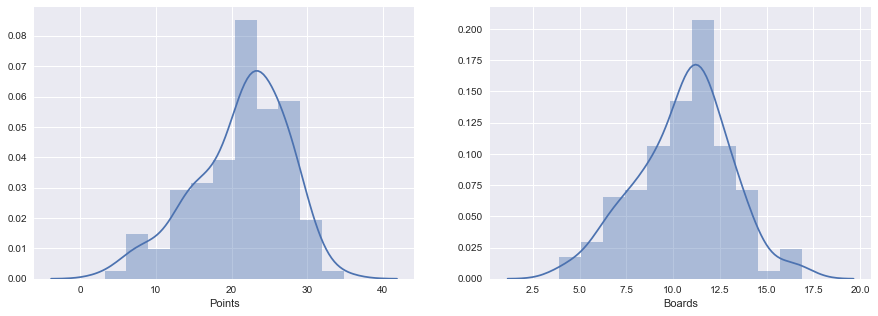

In [14]:
sns.set_style("darkgrid")
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
point_dist = sns.distplot(points, label="Points", ax=ax1)
boards_dist = sns.distplot(boards, label="Boards", ax=ax2)

There appears to be quite low variance in these samples and a slight skew to the left -- this is likely due to the size of the data set (*n*=143). However, considering this analysis is more for expository purposes and there is a relatively normal distribution for each sample, we'll accept the data in its current form.
<hr>
Next, let's view the shape of the relationship between boards and points, specifically our intention is to regress points onto boards.

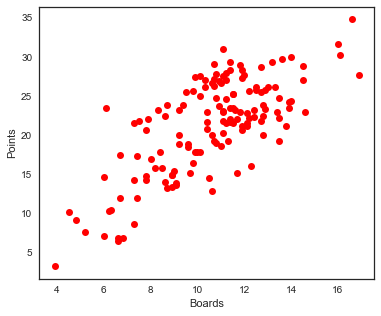

In [15]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(6,5))
ax.plot(boards, points, 'ro')
ax.set_xlabel("Boards")
ax.set_ylabel("Points")

Excellent! We can clearly see the homoscedastic nature of our sample and that simple linear regression is the proper tool for this data set, now lets start the fun stuff

## Simple Linear Regression Analysis
For this section we will be trying to use as little dependencies as possible. I recently had an interesting discussion with a  Python expert regarding which learning method is best for programming: 
<ol>
<li>Results first (namely, use of libraries/built-in functions), the fundamentals will come</li>
<li>Super-strong understanding of the fundamentals, then implement libraries</li>
</ol>

Though he is the Python expert, I have an undergraduate in psychology, thus I will be going with the latter method.

### Formulas
All the formulas I am using are present in *An Introduction to Statistical Learning with Applications in R,* by James et al., 2013.

*Note: At the end of this notebook we'll compare the accuracy of my code to Scipy's*
<hr>

First, let's get everthing we needs to compute our slope. We will be modelling the following equation (p.62)

$$\hat\beta_1=\frac{\sum_{i=0}^n (x_i - \bar{x}) - (y_i - \bar{y})}{(x_i - \bar{x})^2}$$

In [88]:
# Compute the means
boardsMean = sum(boards) / float(len(boards))
pointsMean = sum(points) / float(len(points))
print("boards M: ",boardsMean)
print("points M: ",pointsMean)

boards M:  10.565034965
points M:  21.2097902098


In [24]:
# Calculate the slope, intercept
rise = 0
run = 0
for i, x in enumerate(list(boards)):
    rise += (x - boardsMean) * (list(points)[i] - pointsMean) 
    run += (x - boardsMean) ** 2

In [25]:
# The names of our slope intercept are such to prevent..
# collisions for when we analyze with Scipy
mySlope = rise/run
mySlope

1.8024282801174698

In [26]:
yInter = pointsMean - (mySlope * boardsMean) 
yInter

2.1670724083812942

Now that we have our slope and intercept, let's make sure things went smoothly by checking how well our coefficients fit the data.

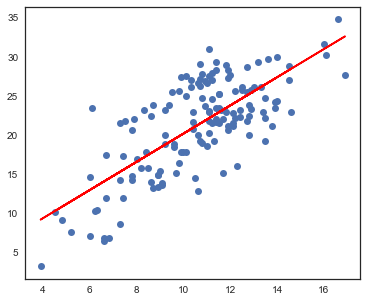

In [27]:
f, ax = plt.subplots(figsize=(6,5))
sns.set_style("white")
scatter = ax.plot(boards, points, 'o', label='Data')
line = ax.plot(boards, yInter + mySlope*boards, 'r', label='fitted line')

Looks pretty good to me. Ok, so we've had our fun, let's find out what this all means!

*For the following code note that "SE" stands for "Standard Error"*

In [67]:
# Compute the residual sum of squares
RSS = 0
for i, y in enumerate(list(points)):
    RSS += (y - (yInter + (mySlope*list(boards)[i])))**2
RSS

2422.880850440316

In [61]:
# Find the residual standard error
RSE = (RSS/(len(boards)-2))** 0.5
RSE

6.1194413443313014

In [74]:
# total sum of squares
TSS = 0
for y in points:
    TSS += (y - pointsMean)**2
TSS

5280.1062937062916

In [80]:
# R squared
myRsquared = 1 - (RSS/TSS)
myRsquared

0.54113028873522717

Now let's see how we stack up with scipy so far...

In [81]:
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(boards,points)

In [86]:
compare_stats = {'me':[mySlope, yInter, myRsquared ** 0.5],
                'scipy':[slope, intercept, r_value]}

comparison_dframe = pd.DataFrame(compare_stats)

In [87]:
comparison_dframe

,me,scipy
0,1.802428,1.802428
1,2.167072,2.167072
2,0.735616,0.735616


**Excellent!** We are accurate to the millionth place! A few more decimal places, however, and the numbers are no longer exact matches, specifically the 16th decimal place (i.e., `1.8024282801174698` > `1.8024282801174696`, where the former value is from Scipy)

In [30]:
SE_slope_squared = (RSE**2)/run
SE_slope_squared

0.019538194187523585

In [45]:
SE_yInter_squared = 0
SE_yInter_squared = (((RSE**2)/(len(points)-2)) + ((RSE**2)*(boardsMean**2)/run))  
SE_yInter_squared

2.302721692219349

In [68]:
t_score = (mySlope-0)/SE_slope_squared**0.5
t_score

12.894834781972383

In [69]:
ci_slope_lower, ci_slope_upper = ((mySlope - (2*(SE_slope_squared**0.5))),(mySlope + (2*(SE_slope_squared**0.5))))
print("There is ~95% probability that the true value of y will fall between {0} and {1} points.".format(round(ci_slope_lower*10,2),
                                                                                                        round(ci_slope_upper*10,2)))

There is ~95% probability that the true value of y will fall between 15.23 and 20.82 points.
